In [2]:
import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import KDTree
# import torch
# from torch_geometric.data import Data
!pip install matplotlib
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm

# import glob

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "/home/udit/anaconda3/envs/mapd/lib/python3.6/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "/home/udit/anaconda3/envs/mapd/lib/python3.6/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/udit/anaconda3/envs/mapd/lib/python3.6/site-packages/pip/_vendor/pkg_resources/__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "/home/udit/anaconda3/envs/mapd/lib/python3.6/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last

In [3]:
data=xr.open_dataset("/home/udit/Documents/Progyan/Ashish_2022_Summer_Work/IMD_Data/_Clim_Pred_LRF_New_RF25_IMD0p252021.nc")
print(data)

<xarray.Dataset>
Dimensions:    (LATITUDE: 129, LONGITUDE: 135, TIME: 365)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 66.75 67.0 67.25 ... 99.5 99.75 100.0
  * LATITUDE   (LATITUDE) float64 6.5 6.75 7.0 7.25 ... 37.75 38.0 38.25 38.5
  * TIME       (TIME) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 16-Mar-22
    Conventions:  CF-1.6


 33%|███▎      | 4/12 [00:20<00:41,  5.24s/it]

FileNotFoundError: No file 2014.


 83%|████████▎ | 10/12 [00:45<00:09,  4.78s/it]

FileNotFoundError: No file 2020.


100%|██████████| 12/12 [00:51<00:00,  4.26s/it]


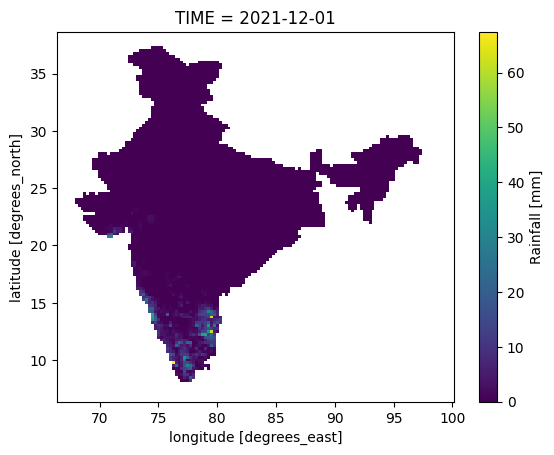

In [3]:
for _ in tqdm(range(2010, 2022)):
    try:
        data=xr.open_dataset(f"/home/udit/Documents/Progyan/Ashish_2022_Summer_Work/IMD_Data/_Clim_Pred_LRF_New_RF25_IMD0p25{_}.nc")
        # print(data)
        lons = data.variables['LONGITUDE'][:]
        lats = data.variables['LATITUDE'][:]
        time = data.variables['TIME'][:]
        ppt = data.variables['RAINFALL'][:]
        for i in range(1, 13):
            plt.clf()
            rain = data.sel(TIME = f'{_}-{i}-01')
            rain['RAINFALL'].plot()
            plt.savefig(f'./plots/{_}_{i}.png')
    except FileNotFoundError:
        print(f"FileNotFoundError: No file {_}.")


In [5]:
year = 2010
file = f"/home/udit/Documents/Progyan/Ashish_2022_Summer_Work/IMD_Data/_Clim_Pred_LRF_New_RF25_IMD0p25{year}.nc"

In [6]:
data=xr.open_dataset(file)
lons = data.variables['LONGITUDE'][:]
lats = data.variables['LATITUDE'][:]
time = data.variables['TIME'][:]
ppt = data.variables['RAINFALL'][:]

In [7]:
# make a list of all the coordinates
coords = []
for i in range(len(lons)):
    for j in range(len(lats)):
        if not np.isnan(data.sel(LATITUDE = lats.values[j], LONGITUDE = lons.values[i])["RAINFALL"]).all():
            coords.append([lons.values[i], lats.values[j]])

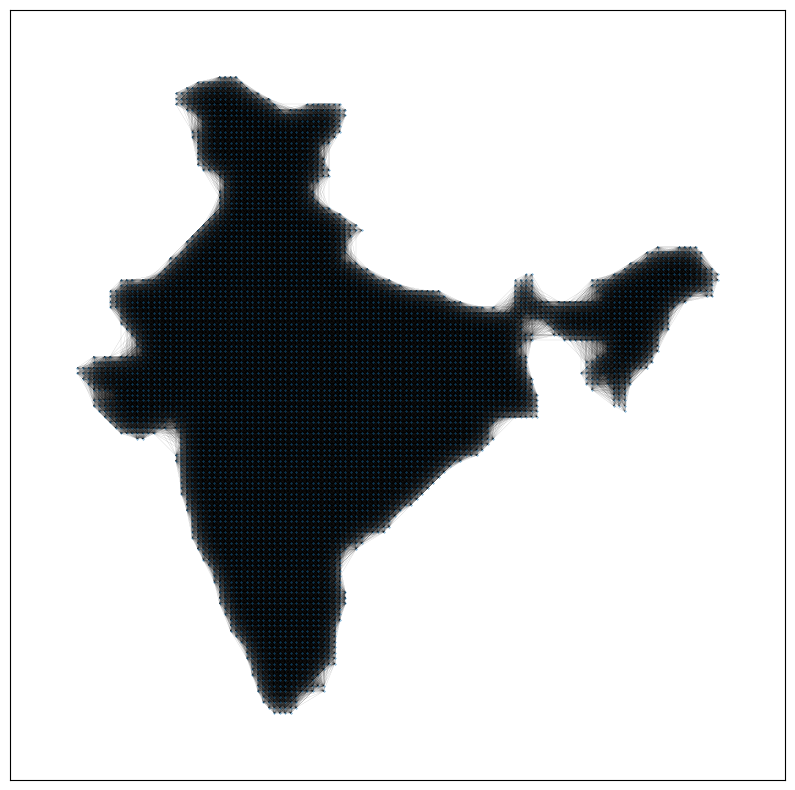

In [8]:
# form a networkx graph with positions at the coordinates and edges between the nearest neighbours
G = nx.Graph()
G.add_nodes_from(range(len(coords)))
G.add_edges_from(KDTree(coords).query_pairs(1.5))

# plot the graph
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos = {i:coords[i] for i in range(len(coords))}, node_size = 0.1, width = 0.05, with_labels = False)


In [8]:
from scipy.signal import find_peaks

# Helper function to compute event synchronization between two nodes
def event_sync(node1, node2, threshold):
    ppt1 = data.sel(LATITUDE=lats[node1], LONGITUDE=lons[node1])['RAINFALL']
    ppt2 = data.sel(LATITUDE=lats[node2], LONGITUDE=lons[node2])['RAINFALL']
    ppt1_events, _ = find_peaks(ppt1, height=threshold)
    ppt2_events, _ = find_peaks(ppt2, height=threshold)
    sync = np.intersect1d(ppt1_events, ppt2_events)
    return len(sync)

In [10]:
threshold = 10 # rainfall threshold for detecting events
edge_weights = {}
for i in tqdm(range(len(lats))[:-1]):
    for j in range(i+1, len(lats)):
        sync = event_sync(i, j, threshold)
        if sync > 0:
            edge_weights[(i, j)] = sync


100%|██████████| 128/128 [00:48<00:00,  2.62it/s]


In [17]:
G = nx.Graph()
# G.add_nodes_from(range(len(lons)))
# G.add_edges_from(edge_weights.keys())
G.add_nodes_from(range(len(coords)))
G.add_edges_from(KDTree(coords).query_pairs(1.5))
nx.set_edge_attributes(G, edge_weights, 'weight')

ValueError: Invalid RGBA argument: 34

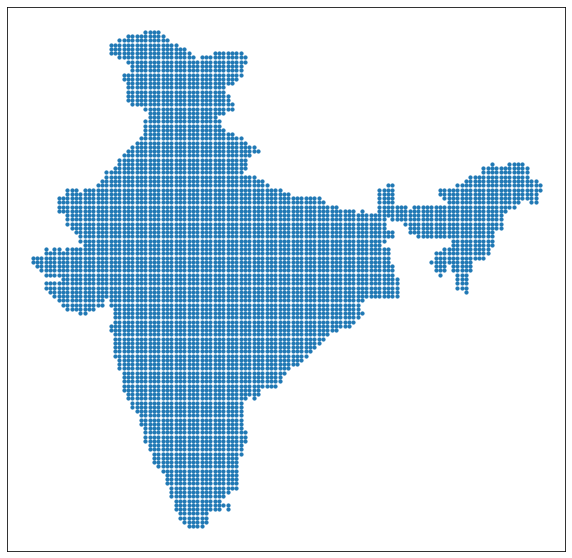

In [19]:

# Plot the network
plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos= {i:coords[i] for i in range(len(coords))}, node_size=10, width=0.5, with_labels=False, cmap=plt.cm.Blues, edge_color=edge_weights.values())
# nx.draw_networkx(G, pos = {i:coords[i] for i in range(len(coords))}, node_size = 0.1, width = 0.05, with_labels = False)

# plt.axis('off')
plt.show()

In [9]:
# Calculate the pairwise synchronicity
corr_matrix = np.zeros((len(lons), len(lats)))
ppt_flat = ppt.values.flatten() # convert to numpy array and flatten
for i in range(len(lons)):
    for j in range(len(lats)):
        corr = np.correlate(ppt[i,j,:], ppt_flat)
        corr_matrix[i,j] = np.max(corr)

# Threshold the synchronicity matrix to create an adjacency matrix
threshold = np.percentile(corr_matrix, 90)
adj_matrix = np.zeros((len(lons), len(lats)))
adj_matrix[corr_matrix >= threshold] = 1

# Create the network and plot it
G = nx.Graph()
for i in range(len(lons)):
    for j in range(len(lats)):
        if adj_matrix[i,j] == 1:
            G.add_edge((lons[i], lats[j]), (lons[j], lats[j]))

pos = {node: node for node in G.nodes()}
nx.draw(G, pos=pos, node_size=10)
plt.show()

KeyboardInterrupt: 

In [21]:
lons = data.variables['LONGITUDE'][:]
lats = data.variables['LATITUDE'][:]

# Helper function to compute event synchronization between two nodes
def event_sync(node1, node2, threshold):
    ppt1 = data.sel(LATITUDE=lats[node1], LONGITUDE=lons[node1])['RAINFALL']
    ppt2 = data.sel(LATITUDE=lats[node2], LONGITUDE=lons[node2])['RAINFALL']
    ppt1_events, _ = find_peaks(ppt1, height=threshold, distance=1)
    ppt2_events, _ = find_peaks(ppt2, height=threshold, distance=1)
    sync = np.intersect1d(ppt1_events, ppt2_events)
    return len(sync)

# Compute edge weights based on event synchronization
threshold = 100 # rainfall threshold for detecting events
edge_weights = {}

In [22]:
for i in tqdm(range(len(lons))):
    for j in range(i+1, len(lons)):
        sync = event_sync(i, j, threshold)
        if sync > 0:
            edge_weights[(i, j)] = sync


  0%|          | 0/135 [00:00<?, ?it/s]


IndexError: index 129 is out of bounds for axis 0 with size 129

In [81]:
adj_matrix = np.load('/home/udit/Documents/Progyan/results_new_95/Decade_1901-1910.npy')


In [82]:
adj_matrix = adj_matrix + adj_matrix.transpose()

In [83]:
# choose a threshold for the adjacency matrix
# choose only those edges that are above the threshold
adj_matrix[adj_matrix < 0.6] = 0

In [84]:
# make diagonal zero
np.fill_diagonal(adj_matrix, 0)

In [85]:
adj_matrix.shape

(4527, 4527)

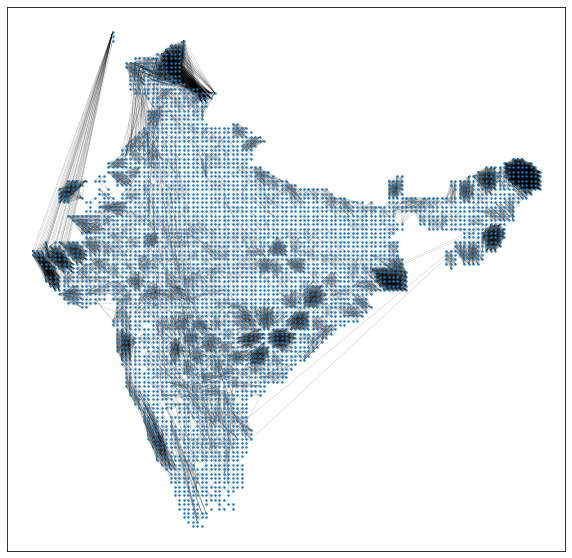

In [86]:
# plot size
plt.figure(figsize=(10,10))
# create graph from adjacency matrix
G = nx.from_numpy_matrix(adj_matrix)

# load latitude and longitude pairs from csv file
lat_lon_df = pd.read_csv('/home/udit/Documents/Progyan/lat_lon-1901.csv')

# create dictionary with node IDs as row indices and lat-lon tuples as values
lat_lon_dict = {}
for i in range(len(lat_lon_df)):
    lat_lon_dict[i] = (lat_lon_df.loc[i, 'lon'], lat_lon_df.loc[i, 'lat'])

# add latitudes and longitudes as node attributes
nx.set_node_attributes(G, lat_lon_dict, 'pos')

# get node positions
pos = nx.get_node_attributes(G, 'pos')

# create new dictionary with node positions only within India's geographical bounds
india_pos = {}
for node_id, coords in pos.items():
    if coords[1] > 5.5 and coords[1] < 38 and coords[0] > 67 and coords[0] < 97:
        india_pos[node_id] = coords

# draw the graph with node positions within India's geographical bounds



nx.draw_networkx(G, pos=india_pos, node_size=2, width=0.1, with_labels=False)

plt.savefig('graph1.png')